# Dataset exploration

In [1]:
import os
os.chdir("/Users/antonioloison/Projects/fakenewsdetec")
os.getcwd()

'/Users/antonioloison/Projects/fakenewsdetec'

In [2]:
import pandas as pd
import plotly.express as px
import math
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import Dict, List

# Import dataset

Before continuing, please download this [dataset](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv) to the `data/` folder.

In [3]:
fake_news = pd.read_csv("data/Fake.csv")
true_news = pd.read_csv("data/True.csv")
print(fake_news.shape)
print(true_news.shape)

(23481, 4)
(21417, 4)


In [4]:
fake_news["label"] = "fake"
true_news["label"] = "true"

In [5]:
all_news = pd.concat([fake_news, true_news]).reset_index(drop=True).sample(frac=1).reset_index(drop=True)
all_news.shape

(44898, 5)

In [6]:
all_news.head()

title  \
0   Bernie Gives Us Hope, Promises To Protect Min...   
1  Tories lead for the first time since June elec...   
2  White House aims to be forthright in Congress ...   
3  France defends Iran nuclear deal, which Trump ...   
4  WORKPLACE MICROAGGRESSION: ISIS Yells “Alluha ...   

                                                text       subject  \
0  The unthinkable has happened, and we are now a...          News   
1  (Reuters) - UK Prime Minister Theresa May s co...     worldnews   
2  WASHINGTON (Reuters) - The Trump administratio...  politicsNews   
3  UNITED NATIONS (Reuters) - France made a new p...  politicsNews   
4  Obviously not the smartest cowards in the dese...     left-news   

                  date label  
0    November 10, 2016  fake  
1   December 11, 2017   true  
2      March 30, 2017   true  
3  September 18, 2017   true  
4         Mar 25, 2016  fake

# Dataset Analysis

## Label Distribution

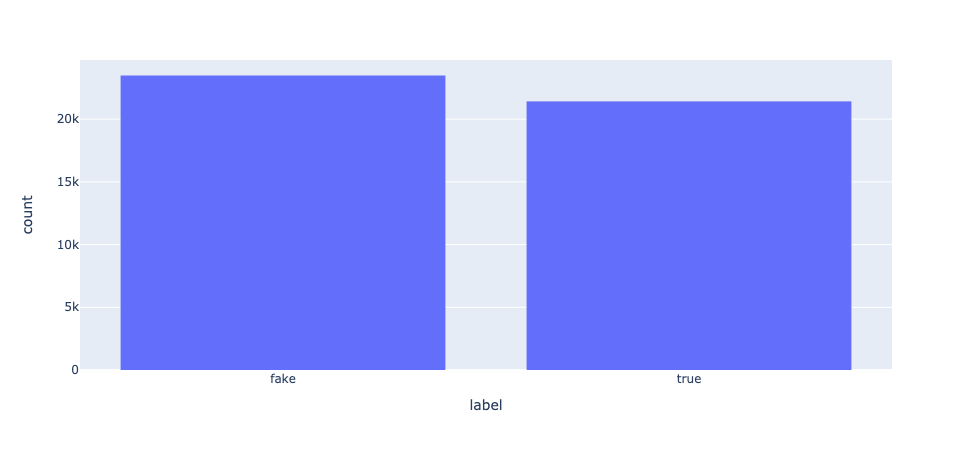

In [7]:
fig = px.histogram(all_news, x="label")
fig.show()

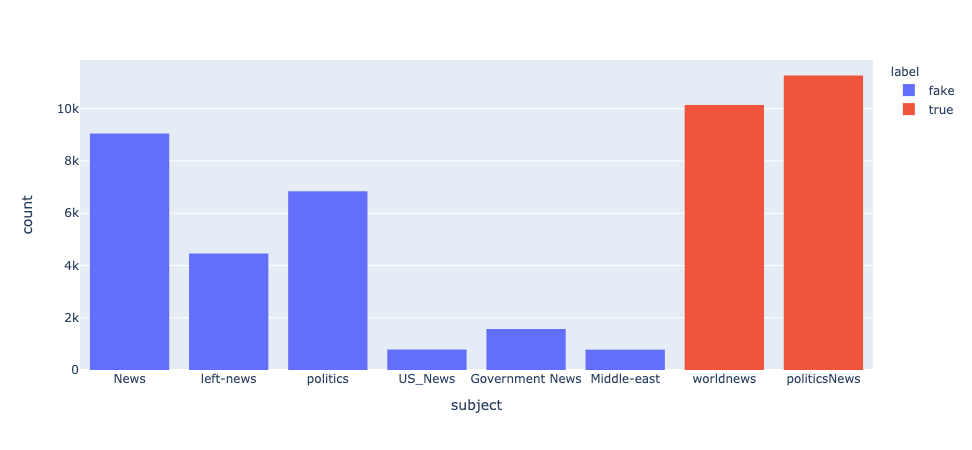

In [8]:
fig = px.histogram(all_news, x="subject", color="label")
fig.show()

In [9]:
all_news["text_length"] = all_news["text"].apply(lambda x: len(x.split(" ")))

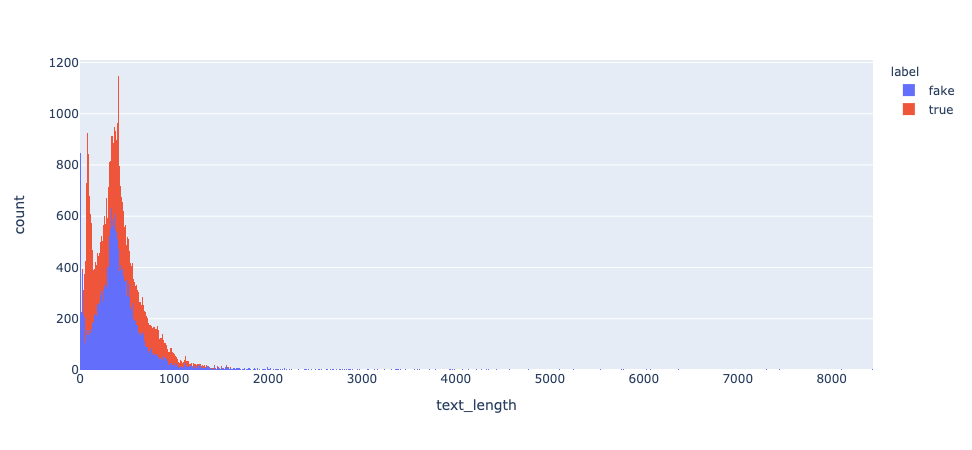

In [10]:
fig = px.histogram(all_news, x="text_length", color="label")
fig.show()

## N-gram analysis

In [11]:
def get_top_ngrams(corpus, ngram_len: int=1) -> List:
    vec = CountVectorizer(ngram_range=(ngram_len, ngram_len), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [12]:
print("Counting 1-gram in true samples...")
top_unigrams_true = get_top_ngrams(all_news[all_news["label"] == "true"].text, 1)
print("Counting 1-gram in false samples...")
top_unigrams_false = get_top_ngrams(all_news[all_news["label"] == "fake"].text, 1)

Counting 1-gram in true samples...
Counting 1-gram in false samples...


In [13]:
true_state_distr = pd.DataFrame(top_unigrams_true[:200], columns=["unigram", "count"])
fake_state_distr = pd.DataFrame(top_unigrams_false[:200], columns=["unigram", "count"])


In [14]:
true_set = set(true_state_distr["unigram"])
fake_set = set(fake_state_distr["unigram"])
uoi = (true_set | fake_set) - (true_set & fake_set)
prop = round(len(uoi)/len(list(true_state_distr["unigram"])+list(fake_state_distr["unigram"]))*100, 2)
print(f"Proportion of ngrams over-represented in only one class: {prop}% ")
counting = []
for x in uoi:
    if x in true_set:
        counting.append((x, true_state_distr[true_state_distr["unigram"] == x].reset_index().loc[0,"count"], "true"))
    else:
        counting.append((x, fake_state_distr[fake_state_distr["unigram"] == x].reset_index().loc[0,"count"], "fake"))
sorted(counting, key=lambda x: x[1], reverse=True)

Proportion of ngrams over-represented in only one class: 47.0% 


[('reuters', 28976, 'true'),
 ('hillary', 14122, 'fake'),
 ('twitter', 11721, 'fake'),
 ('america', 11185, 'fake'),
 ('know', 10383, 'fake'),
 ('north', 9912, 'true'),
 ('image', 9895, 'fake'),
 ('china', 8865, 'true'),
 ('minister', 8682, 'true'),
 ('com', 8508, 'fake'),
 ('video', 8338, 'fake'),
 ('tuesday', 8268, 'true'),
 ('featured', 8260, 'fake'),
 ('tax', 8192, 'true'),
 ('wednesday', 8014, 'true'),
 ('black', 7731, 'fake'),
 ('thursday', 7662, 'true'),
 ('women', 7396, 'fake'),
 ('friday', 7332, 'true'),
 ('korea', 7277, 'true'),
 ('monday', 7097, 'true'),
 ('americans', 6780, 'fake'),
 ('man', 6618, 'fake'),
 ('watch', 6602, 'fake'),
 ('committee', 6400, 'true'),
 ('pic', 6292, 'fake'),
 ('fact', 6279, 'fake'),
 ('really', 6214, 'fake'),
 ('official', 6141, 'true'),
 ('trade', 5964, 'true'),
 ('deal', 5892, 'true'),
 ('story', 5866, 'fake'),
 ('fbi', 5802, 'fake'),
 ('iran', 5802, 'true'),
 ('month', 5722, 'true'),
 ('leader', 5717, 'true'),
 ('didn', 5647, 'fake'),
 ('ve', 55

# Analyze articles format

In [15]:
THRESHOLD = 0

## True articles

In [16]:
counter = 0
for i, row in all_news.iterrows(): 
    if row["label"] == "true" and counter <= THRESHOLD:
        print(row["text"])
        print("\n")
        counter += 1

(Reuters) - UK Prime Minister Theresa May s conservative party is leading in polls for the first time since the June election, according to a YouGov poll for the Times. Theresa May s advantage over Labour party s Jeremy Corbyn has doubled, the newspaper said. The YouGov poll, conducted on Sunday and Monday among 1,680 adults, suggested that May s Brexit deal appears to have improved her public standing and pushed the Tories ahead on 42 per cent with Labour at 41 per cent of the vote.  Liberal Democrats were at 7 per cent and the rest on 10 per cent, Times said. The public still does not think that the government is doing a good job on Brexit, but, Theresa May was the preferred choice for  best prime minister  with 37 percent of the votes. Only 28 percent voted for Jeremy Corbyn. The paper added that public did not shift its view on the referendum with 44 percent saying that Britain was right to vote to leave, and, 45 per cent said it was the wrong choice. 




## Fake articles

In [17]:
counter = 0
for i, row in all_news.iterrows(): 
    if row["label"] == "fake" and counter <= THRESHOLD:
        print(row["text"])
        print("\n")
        counter += 1

The unthinkable has happened, and we are now all forced to live under a Donald Trump administration for the next four years. This is especially terrifying to minorities, since the man that was just declared our next president is a racist, misogynistic, xenophobic bigot, and his vice president-elect, Indiana Governor Mike Pence, is just as bad   only much more quietly. Well, there is one person in the United States Senate who won t stand for any of that bigotry when it comes to lawmaking: Bernie Sanders.While Bernie has promised to work with a Trump administration where they can find common ground, he has already warned Trump that there will be no funny business on his watch when it comes to going after minorities. Bernie tweeted:If Donald Trump takes people's anger and turns it against Muslims, Hispanics, African Americans and women, we will be his worst nightmare.  Bernie Sanders (@SenSanders) November 10, 2016This isn t the first time since Trump s victory that Bernie has warned him 

**==> Clear data bias:** All the true articles start with CITY (Reuters) - 

# Topic modeling

In [18]:
def print_topics(model: TruncatedSVD, vectorizer: TfidfVectorizer, top_n: int=10) -> None:
    for idx, topic in enumerate(model.components_):
        print("Topic %d: " % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
        print("\n")
        
def run_lsa_and_print_topics(df: pd.DataFrame, num_topics: int=5, num_words: int=5) -> None:
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
    lsa_model = TruncatedSVD(n_components=num_topics)
    tfidf_transformed = tfidf_vectorizer.fit_transform(df.text)
    lsa_transform = lsa_model.fit_transform(tfidf_transformed)
    print_topics(lsa_model, tfidf_vectorizer)

In [19]:
run_lsa_and_print_topics(all_news)


Topic 0: 
[('trump', 0.40801975777831273), ('said', 0.23992586705225305), ('president', 0.14785036182386235), ('clinton', 0.12783230717984415), ('house', 0.10879604567933567), ('obama', 0.10792791816766799), ('republican', 0.10478591489237749), ('donald', 0.09663059036570265), ('people', 0.0947425374469487), ('state', 0.09175533602903382)]


Topic 1: 
[('korea', 0.25570564962096404), ('north', 0.23273728884658773), ('said', 0.20278630234766898), ('china', 0.15337152824701317), ('nuclear', 0.13965924496490084), ('iran', 0.11936617211422519), ('united', 0.11721009120835002), ('reuters', 0.10704569927320502), ('minister', 0.09744178639421025), ('missile', 0.09654330474201764)]


Topic 2: 
[('trump', 0.44913546508163443), ('korea', 0.3562441614299072), ('north', 0.29708007471901193), ('china', 0.1758548479783957), ('nuclear', 0.15544301384346157), ('korean', 0.12631424690239085), ('russia', 0.10834786527777622), ('missile', 0.10375264672461879), ('donald', 0.09134984259698828), ('pyongyang

# Sentiment Analysis

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [21]:
analyzer = SentimentIntensityAnalyzer()


In [22]:
def extract_compound_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["compound"]

def extract_pos_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["pos"]

def extract_neg_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["neg"]

def extract_neu_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["neu"]

In [23]:
news_compound = all_news.iloc[:1000,:].text.apply(lambda x: extract_compound_sentiment(x))

In [24]:
news_compound_df = pd.DataFrame()
news_compound_df["label"] = all_news["label"].iloc[:1000]
news_compound_df["polarity"] = news_compound

In [25]:
news_compound

0     -0.8664
1      0.8201
2      0.7351
3      0.9173
4     -0.4973
        ...  
995    0.9217
996    0.5386
997   -0.9039
998   -0.9962
999   -0.9979
Name: text, Length: 1000, dtype: float64

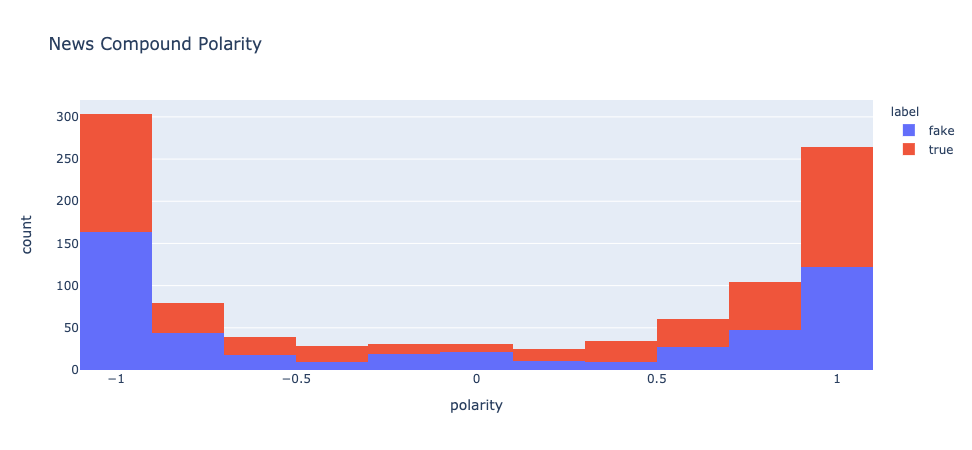

In [26]:
px.histogram(news_compound_df, x=news_compound.values, labels={"x": "polarity"}, title="News Compound Polarity", color="label")
